In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0637

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - loss: 0.0501
Average validation loss: 0.6234908103942871
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - loss: 0.0501 - val_loss: 0.6235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - loss: 0.0355 - val_loss: 0.6235
Average validation loss: 0.5209701061248779
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step - loss: 0.0355 - val_loss: 0.5722
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 491ms/step - loss: 0.0274 - val_loss: 0.5722
Average validation loss: 0.4970730245113373
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 502ms/step - loss: 0.0274 - val_loss: 0.5472
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 485ms/step - loss: 1.7033e-04
Average validation loss: 0.4091779738664627
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - loss: 1.7033e-04 - val_loss: 0.4092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 488ms/step - loss: 1.6825e-04 - val_loss: 0.4092
Average validation loss: 0.15912937000393867
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 497ms/step - loss: 1.6825e-04 - val_loss: 0.2842
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 483ms/step - loss: 1.5968e-04 - val_loss: 0.2842
Average validation loss: 0.11878613382577896
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - loss: 1.5968e-04 - val_loss: 0.2290
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weig

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - loss: 5.6123e-05
Average validation loss: 0.1042907436688741
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step - loss: 5.6123e-05 - val_loss: 0.1043
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 486ms/step - loss: 4.4521e-05 - val_loss: 0.1043
Average validation loss: 0.037247736006975174
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 495ms/step - loss: 4.4521e-05 - val_loss: 0.0708
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 487ms/step - loss: 4.2313e-05 - val_loss: 0.0708
Average validation loss: 0.05420125648379326
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 495ms/step - loss: 4.2313e-05 - val_loss: 0.0652
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - loss: 3.9300e-05 - val_loss

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - loss: 2.0994e-05
Average validation loss: 0.05883059184998274
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step - loss: 2.0994e-05 - val_loss: 0.0588
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 484ms/step - loss: 1.7900e-05 - val_loss: 0.0588
Average validation loss: 0.027482042263727635
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 493ms/step - loss: 1.7900e-05 - val_loss: 0.0432
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 484ms/step - loss: 2.3402e-05 - val_loss: 0.0432
Average validation loss: 0.21598313003778458
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 492ms/step - loss: 2.3402e-05 - val_loss: 0.1008
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 485ms/step - loss: 1.9222e-05 - val_los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - loss: 3.0283e-05
Average validation loss: 0.03393416497856379
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - loss: 3.0283e-05 - val_loss: 0.0339
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 480ms/step - loss: 2.0978e-05 - val_loss: 0.0339
Average validation loss: 0.0138000444509089
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - loss: 2.0978e-05 - val_loss: 0.0239
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 480ms/step - loss: 1.5296e-05 - val_loss: 0.0239
Average validation loss: 0.012488521263003349
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 488ms/step - loss: 1.5296e-05 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_se

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - loss: 4.0143e-05
Average validation loss: 0.03230049697837482
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 492ms/step - loss: 4.0143e-05 - val_loss: 0.0323
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 483ms/step - loss: 2.8443e-05 - val_loss: 0.0323
Average validation loss: 0.009379821829497814
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 490ms/step - loss: 2.8443e-05 - val_loss: 0.0208
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 483ms/step - loss: 2.2111e-05 - val_loss: 0.0208
Average validation loss: 0.022497062920592725
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 491ms/step - loss: 2.2111e-05 - val_loss: 0.0214
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 486ms/step - loss: 1.8395e-05 - val_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 483ms/step - loss: 2.0783e-05
Average validation loss: 0.026457870122976603
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - loss: 2.0783e-05 - val_loss: 0.0265
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 485ms/step - loss: 1.6276e-05 - val_loss: 0.0265
Average validation loss: 0.025819042418152093
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 493ms/step - loss: 1.6276e-05 - val_loss: 0.0261
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 488ms/step - loss: 1.2923e-05 - val_loss: 0.0261
Average validation loss: 0.02006492728833109
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 496ms/step - loss: 1.2923e-05 - val_loss: 0.0241
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 483ms/step - loss: 1.3029e-05
Average validation loss: 0.014582275762222707
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 491ms/step - loss: 1.3029e-05 - val_loss: 0.0146
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 485ms/step - loss: 9.8257e-06 - val_loss: 0.0146
Average validation loss: 0.019423176456863683
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 493ms/step - loss: 9.8257e-06 - val_loss: 0.0170
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 484ms/step - loss: 7.6447e-06 - val_loss: 0.0170
Average validation loss: 0.011626135169838866
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 491ms/step - loss: 7.6447e-06 - val_loss: 0.0152
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 94s 482ms/step - loss: 6.3614e-06 - val

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 480ms/step - loss: 7.4139e-06
Average validation loss: 0.01324130195592131
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 488ms/step - loss: 7.4139e-06 - val_loss: 0.0132
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 486ms/step - loss: 5.6374e-06 - val_loss: 0.0132
Average validation loss: 0.08433317220104593
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 493ms/step - loss: 5.6374e-06 - val_loss: 0.0488
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 486ms/step - loss: 4.5715e-06 - val_loss: 0.0488
Average validation loss: 0.009926231311900275
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 493ms/step - loss: 4.5715e-06 - val_loss: 0.0358
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 483ms/step - loss: 4.1438e-06 - val_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 485ms/step - loss: 4.1358e-06
Average validation loss: 0.011099820912932046
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 493ms/step - loss: 4.1358e-06 - val_loss: 0.0111
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 485ms/step - loss: 3.1842e-06 - val_loss: 0.0111
Average validation loss: 0.012740066478727385
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 492ms/step - loss: 3.1842e-06 - val_loss: 0.0119
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 94s 481ms/step - loss: 2.7112e-06 - val_loss: 0.0119
Average validation loss: 0.011110179708339274
64/64 ━━━━━━━━━━━━━━━━━━━━ 94s 488ms/step - loss: 2.7112e-06 - val_loss: 0.0117
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 125s 486ms/step - loss: 2.3916e-06 - val_loss: 0.0117
Average validation loss: 0.23932817997410893
64/64 ━━━━━━━━━━━━━━━━━━━━ 126s 493ms/step - loss: 2.3916e-06 - val_loss: 0.0686
Epoch 5/10

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 490ms/step - loss: 2.1519e-06
Average validation loss: 0.012405163842938945
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - loss: 2.1519e-06 - val_loss: 0.0124
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 488ms/step - loss: 1.5903e-06 - val_loss: 0.0124
Average validation loss: 0.008370918260576824
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 495ms/step - loss: 1.5903e-06 - val_loss: 0.0104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 490ms/step - loss: 1.3670e-06 - val_loss: 0.0104
Average validation loss: 0.010363980550512982
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 498ms/step - loss: 1.3670e-06 - val_loss: 0.0104
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 143s 491ms/step - loss: 1.1894e-06 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 490ms/step - loss: 2.9246e-06
Average validation loss: 0.006333446223288774
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 497ms/step - loss: 2.9246e-06 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 488ms/step - loss: 3.3617e-06 - val_loss: 0.0063
Average validation loss: 0.007263387554849033
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 496ms/step - loss: 3.3617e-06 - val_loss: 0.0068
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 491ms/step - loss: 2.6461e-06 - val_loss: 0.0068
Average validation loss: 0.00570315078512067
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 498ms/step - loss: 2.6461e-06 - val_loss: 0.0064
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_100.pth'.
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 159s 491ms/step - loss: 2.2072e-06 -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 490ms/step - loss: 3.8419e-06
Average validation loss: 0.015054181858431548
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 497ms/step - loss: 3.8419e-06 - val_loss: 0.0151
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 489ms/step - loss: 3.1342e-06 - val_loss: 0.0151
Average validation loss: 0.009433342755073681
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 496ms/step - loss: 3.1342e-06 - val_loss: 0.0122
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 142s 490ms/step - loss: 2.6087e-06 - val_loss: 0.0122
Average validation loss: 0.009044168327818625
96/96 ━━━━━━━━━━━━━━━━━━━━ 143s 497ms/step - loss: 2.6087e-06 - val_loss: 0.0112
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weight

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 58s 483ms/step - loss: 1.0965e-05
Average validation loss: 0.05190279611075918
120/120 ━━━━━━━━━━━━━━━━━━━━ 59s 491ms/step - loss: 1.0965e-05 - val_loss: 0.0519
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 117s 484ms/step - loss: 7.6453e-06 - val_loss: 0.0519
Average validation loss: 0.006838347432979693
120/120 ━━━━━━━━━━━━━━━━━━━━ 118s 491ms/step - loss: 7.6453e-06 - val_loss: 0.0294
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 176s 480ms/step - loss: 5.9636e-06 - val_loss: 0.0294
Average validation loss: 0.23524604539076488
120/120 ━━━━━━━━━━━━━━━━━━━━ 176s 488ms/step - loss: 5.9636e-06 - val_loss: 0.0980
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 235s 485ms/step - los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 490ms/step - loss: 1.0134e-05
Average validation loss: 0.03479271664077209
144/144 ━━━━━━━━━━━━━━━━━━━━ 72s 498ms/step - loss: 1.0134e-05 - val_loss: 0.0348
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 142s 490ms/step - loss: 7.0615e-06 - val_loss: 0.0348
Average validation loss: 0.008732478806955947
144/144 ━━━━━━━━━━━━━━━━━━━━ 143s 498ms/step - loss: 7.0615e-06 - val_loss: 0.0218
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 214s 492ms/step - loss: 5.5254e-06 - val_loss: 0.0218
Average validation loss: 0.010972831823487973
144/144 ━━━━━━━━━━━━━━━━━━━━ 215s 499ms/step - loss: 5.5254e-06 - val_loss: 0.0182
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 286s 492ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 79s 491ms/step - loss: 3.4131e-06
Average validation loss: 0.008728110895026476
160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 498ms/step - loss: 3.4131e-06 - val_loss: 0.0087
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 158s 490ms/step - loss: 2.6580e-06 - val_loss: 0.0087
Average validation loss: 0.007168731078854762
160/160 ━━━━━━━━━━━━━━━━━━━━ 159s 497ms/step - loss: 2.6580e-06 - val_loss: 0.0079
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 238s 493ms/step - loss: 2.2305e-06 - val_loss: 0.0079
Average validation loss: 0.006515045842388645
160/160 ━━━━━━━━━━━━━━━━━━━━ 239s 501ms/step - loss: 2.2305e-06 - val_loss: 0.0075
Saved model weights to 'c:\天_11157065\git\RipplesDetection\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 492ms/step - loss: 2.8141e-06
Average validation loss: 0.05767506494962447
200/200 ━━━━━━━━━━━━━━━━━━━━ 100s 499ms/step - loss: 2.8141e-06 - val_loss: 0.0577
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 198s 492ms/step - loss: 2.2059e-06 - val_loss: 0.0577
Average validation loss: 0.006401988160505425
200/200 ━━━━━━━━━━━━━━━━━━━━ 200s 499ms/step - loss: 2.2059e-06 - val_loss: 0.0320
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 298s 491ms/step - loss: 1.8761e-06 - val_loss: 0.0320
Average validation loss: 0.006432736993010621
200/200 ━━━━━━━━━━━━━━━━━━━━ 299s 498ms/step - loss: 1.8761e-06 - val_loss: 0.0235
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 398s 491ms/step - l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 116s 483ms/step - loss: 2.2142e-06
Average validation loss: 0.007777357202273075
240/240 ━━━━━━━━━━━━━━━━━━━━ 118s 491ms/step - loss: 2.2142e-06 - val_loss: 0.0078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 234s 482ms/step - loss: 1.7052e-06 - val_loss: 0.0078
Average validation loss: 0.006776987466582796
240/240 ━━━━━━━━━━━━━━━━━━━━ 235s 489ms/step - loss: 1.7052e-06 - val_loss: 0.0073
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_50\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 351s 482ms/step - loss: 1.4063e-06 - val_loss: 0.0073
Average validation loss: 0.009168368238787632
240/240 ━━━━━━━━━━━━━━━━━━━━ 353s 490ms/step - loss: 1.4063e-06 - val_loss: 0.0079
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 469s 483ms/step -

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.2285764742642641, 0.11819515938870609, 0.06166645496307562, 0.02403561660903506, 0.10837311747297644, 0.07796667093896152, 0.03091796343738679, 0.014288736448991889, 0.040577636858381866, 0.016792630433628802, 0.01137198813912821, 0.012928080607758604, 0.011024794113715566, 0.024933776759290288, 0.011711470721581073, 0.009307562716048323, 0.00945275071699507, 0.01066222370154115]
std_val_losses =  [0.15222891999612698, 0.09063151233379407, 0.09010618088535426, 0.0328886274104587, 0.1592137607148738, 0.10657409153658405, 0.043703475490218094, 0.013028730616409887, 0.06618029002068726, 0.034693355300442236, 0.011632807366718598, 0.01855592141383902, 0.014622266658698554, 0.04092283551419579, 0.010516539192884155, 0.005123447861974347, 0.008048068693323826, 0.01218477573270603]


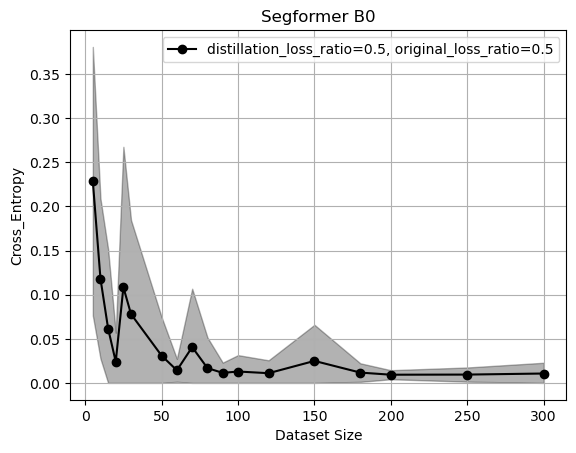

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()